In [1]:
import os
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings
warnings.simplefilter('ignore', category=NumbaWarning)
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

import muon as mu
# Import a module with ATAC-seq-related functions
from muon import atac as ac

from matplotlib import pyplot as plt
import seaborn as sns

sc.set_figure_params(
    scanpy=True, dpi_save=600, vector_friendly=True, format="pdf",
    facecolor=(1.0, 1.0, 1.0, 0.0), transparent=False
)

from matplotlib import rcParams
rcParams["savefig.bbox"] = "tight"
rcParams["savefig.dpi"] = 600

/home/chaozhong/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import treasmo.tl
import treasmo.core
import treasmo.ds
import treasmo.pl

/home/chaozhong/miniconda3/lib/python3.10/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


#### Data Preparation

In [3]:
# MuData with 
#    log-transformed scRNA-seq
#    log(TF) * log(IDF) scATAC-seq data
mudata = mu.read("data/muon_out/HSPC_Muon_processed.h5mu")
mudata.mod['rna'].obs['annotation'] = mudata.obs['annotation'].copy()
mudata.mod['atac'].obs['annotation'] = mudata.obs['annotation'].copy()

mudata = treasmo.tl.feature_sparsity(mudata, group_by={'rna':'annotation',
                                                       'atac':'annotation'})
#mudata.write('HSPC_done.h5mu') # can save the object since it takes some time to run feature_sparsity()
#mudata = mu.read('HSPC_done.h5mu')

In [4]:
hvgs = mudata.mod['rna'].var_names[mudata.mod['rna'].var.highly_variable].to_numpy()
genes = hvgs
peaks = mudata.mod['atac'].var_names[mudata.mod['atac'].var['Frac.all']>=0.01]
upstream, downstream = 50000, 0
ref_gtf_fn = 'data/Homo_sapiens.GRCh38.104.GeneLoc.Tab.txt'

In [5]:
pairsDF = treasmo.tl.peaks_within_distance(genes, peaks, upstream, downstream, ref_gtf_fn,
                                           no_intersect=True, id_type='Ensembl', split_symbol=[':','-'])

Remove nearby peaks if it lies on the gene body or promoter regions of other genes.


In [7]:
print("Number of pairs: ",pairsDF.shape[0])
print("Number of genes: ",len(pairsDF['Gene'].unique()))
print("Number of peaks: ",len(pairsDF['Peak'].unique()))


Number of pairs:  29138
Number of genes:  3171
Number of peaks:  27852


#### Core function

In [8]:
pairsDF = treasmo.core.Global_L(mudata, pairsDF, mods=['rna','atac'], permutations=0,
                                percent=0.1, seed=1, max_RAM=72)

Calculating KNN graph-based global correlation...


/home/chaozhong/treasmo/treasmo/lee_vec.py:62: RuntimeWarning: invalid value encountered in matmul
  self.ctc = self.connectivity.T @ self.connectivity


Finished calculating correlation. 167.205s past


In [9]:
pairsDF.to_csv('results/HSPC_GlobalL.csv')

In [10]:
mudata = treasmo.core.Local_L(mudata, 
                              genes=pairsDF['Gene'].tolist(), 
                              peaks=pairsDF['Peak'].tolist(),
                              mods=['rna','atac'],
                              rm_dropout=False,
                              seed=1, max_RAM=72)

Inferring KNN graph-based local correlation...
Following changes made to the AnnData object:
	KNN graph-based local correlation results saved in uns['Local_L']
	Gene-peak pair names saved in uns['Local_L_names']
Finished Inferring local correlation. 80.894s past


In [11]:
PearSonDf = treasmo.core.Pearsonr(mudata,
                                  genes=pairsDF['Gene'].tolist(),
                                  peaks=pairsDF['Peak'].tolist(),
                                  mods=['rna','atac'],
                                  p_value=False, seed=1)

In [12]:
PearSonDf.to_csv('results/HSPC_Pearson.csv')

In [13]:
# Calculate the consistency between global L and pearson's r
pearsonDf = pd.read_csv('results/HSPC_Pearson.csv')
treasmoDF = pd.read_csv('results/HSPC_GlobalL.csv')
x = pearsonDf['r'].to_numpy()
y = treasmoDF['L'].to_numpy()

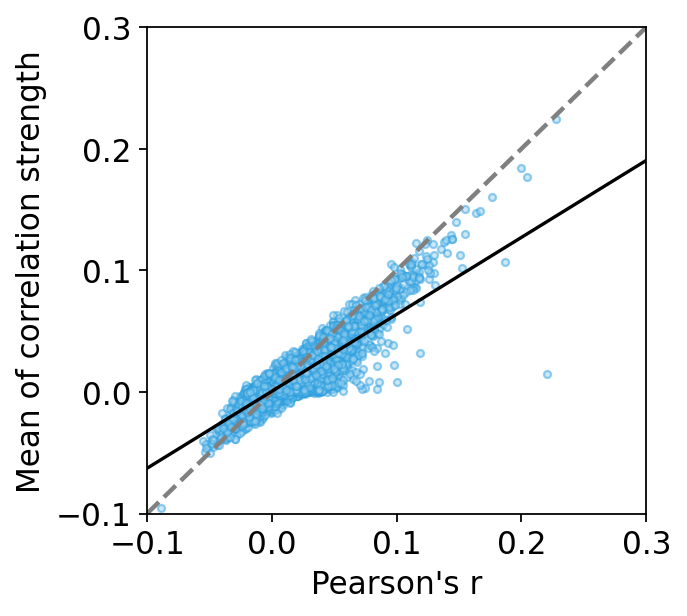

In [14]:
fig, ax = plt.subplots(figsize = (4, 4))

a,b = 0, 1
xseq = np.linspace(-0.1, 0.4, num=100)
ax.plot(xseq, a + b * xseq, '--', color="grey", lw=2)
ax.scatter(x, y, s=10, alpha=0.5, c='#9dd3f0', edgecolor='#2ea0e0')

ax.grid(which='both', linestyle='-', linewidth='0')
ax.set_xlim(-0.1, 0.3)
ax.set_ylim(-0.1, 0.3)

b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(-0.1, 0.4, num=100)
ax.plot(xseq, a + b * xseq, '-', color="k", lw=1.5)
ax.grid(which='both', linestyle='-', linewidth='0')
ax.set_xlim(-0.1, 0.3)
ax.set_ylim(-0.1, 0.3)
ax.set_xlabel("Pearson's r")
ax.set_ylabel("Mean of correlation strength")

plt.savefig('figures/r_L_cor.png')

In [15]:
import scipy as sp
sp.stats.pearsonr(y, x)

PearsonRResult(statistic=0.8667674667536577, pvalue=0.0)

#### Detect regulatory dynamics among groups

In [16]:
MarkerDf = treasmo.ds.FindAllMarkers(mudata, ident='annotation',
                                     mods=['rna','atac'],
                                     corrct_method='bonferroni', seed=1)

Performing statistical test for correlation differences among identities...
Completed! 309.52s past.


/home/chaozhong/miniconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


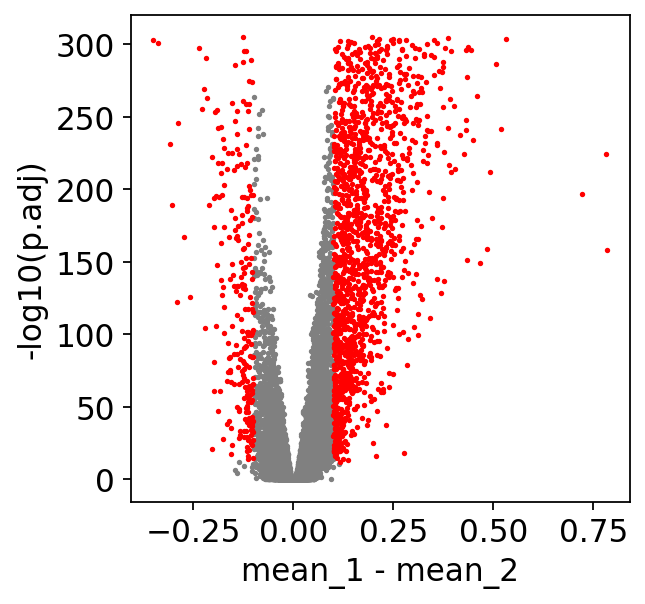

In [17]:
MarkerDf_filt = treasmo.ds.MarkerFilter(MarkerDf, mean_diff=0.1,
                                      min_pct_rna=0.1, min_pct_atac=0.05,
                                      p_cutoff=1e-12, plot=True)
MarkerDf_filt.to_csv("results/HSPC_regulatory_markers.csv")

/home/chaozhong/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


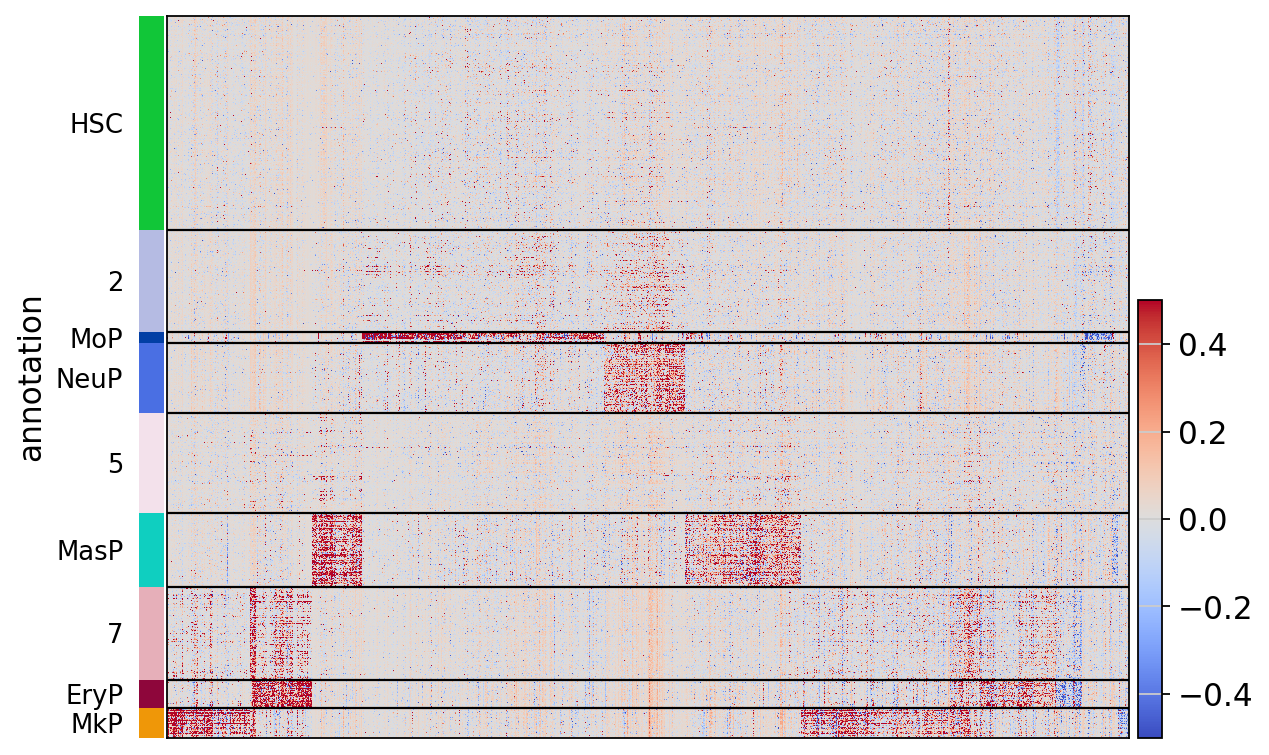

In [18]:
treasmo.pl.LocalCor_Heatmap(mudata, pairs=np.unique(MarkerDf_filt['name']),
                            cluster=True, groupby='annotation', save='figures/HSPC_markers_heatmap.pdf',
                            cmap='coolwarm',
                            vmin=-0.5, vmax=0.5)

#### Single path analysis

Empty bins removed. 101 bins left


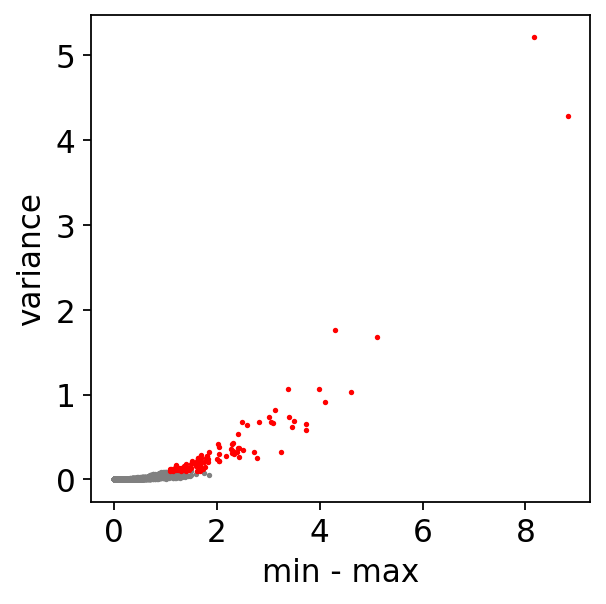

In [19]:
dynamicDf = treasmo.ds.FindPathDynamics(mudata, ident='annotation', 
                                        path=['HSC','5','7','EryP'],
                                        range_cutoff=0.5,
                                        var_cutoff=0.1,
                                        pseudotime='dpt_pseudotime', plot=True)

In [20]:
#ENSG00000198838
#ENSG00000163219
#ENSG00000168477
gene = 'ENSG00000198838'
#peaks = pairsDF.loc[pairsDF['Gene']==gene,'Peak'].tolist()
dynamicDf['Gene'] = dynamicDf.index.str.split('~').str[0]
dynamicDf['Peak'] = dynamicDf.index.str.split('~').str[1]
peaks = dynamicDf.loc[dynamicDf['Gene']==gene]['Peak'].tolist()

In [21]:
mudata = treasmo.ds.PathDynamics(mudata, 
                                 gene=gene,
                                 peaks=peaks, 
                                 ident='annotation',
                                 path=['HSC','5','7','EryP'],
                                 pseudotime='dpt_pseudotime',
                                 bins=100)

Empty bins removed. 101 bins left


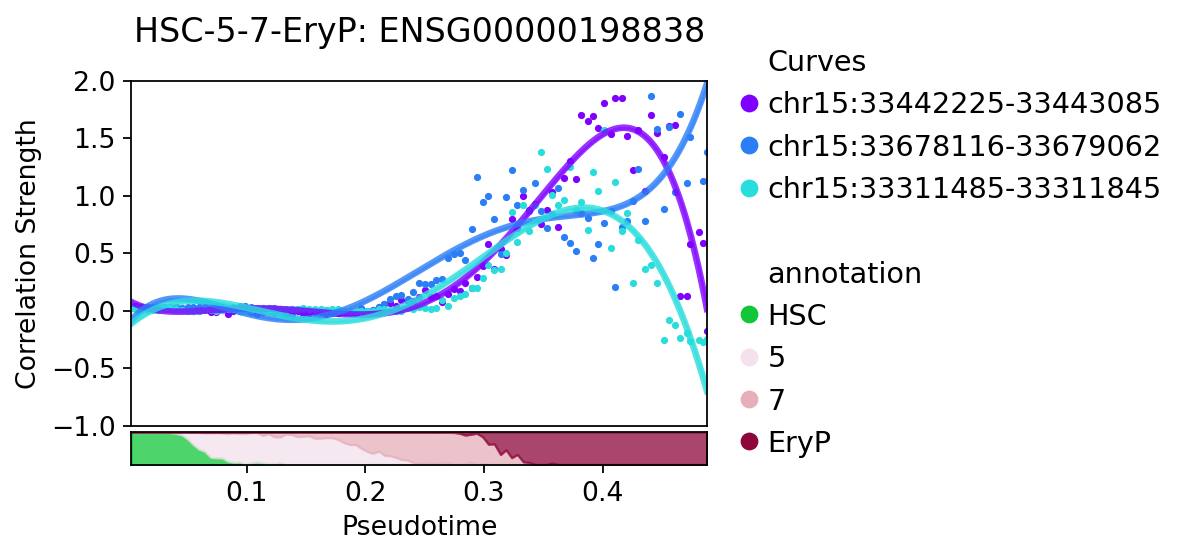

In [22]:
treasmo.pl.PathDynamics(mudata, 
                        gene=gene,
                        #xlim=(0,0.52),
                        ylim=(-1.0,2),
                        ident='annotation',
                        path=['HSC','5','7','EryP'], save='figures/curve_ENSG00000198838.pdf')

ENSG00000198838 and chr15:33442225-33443085


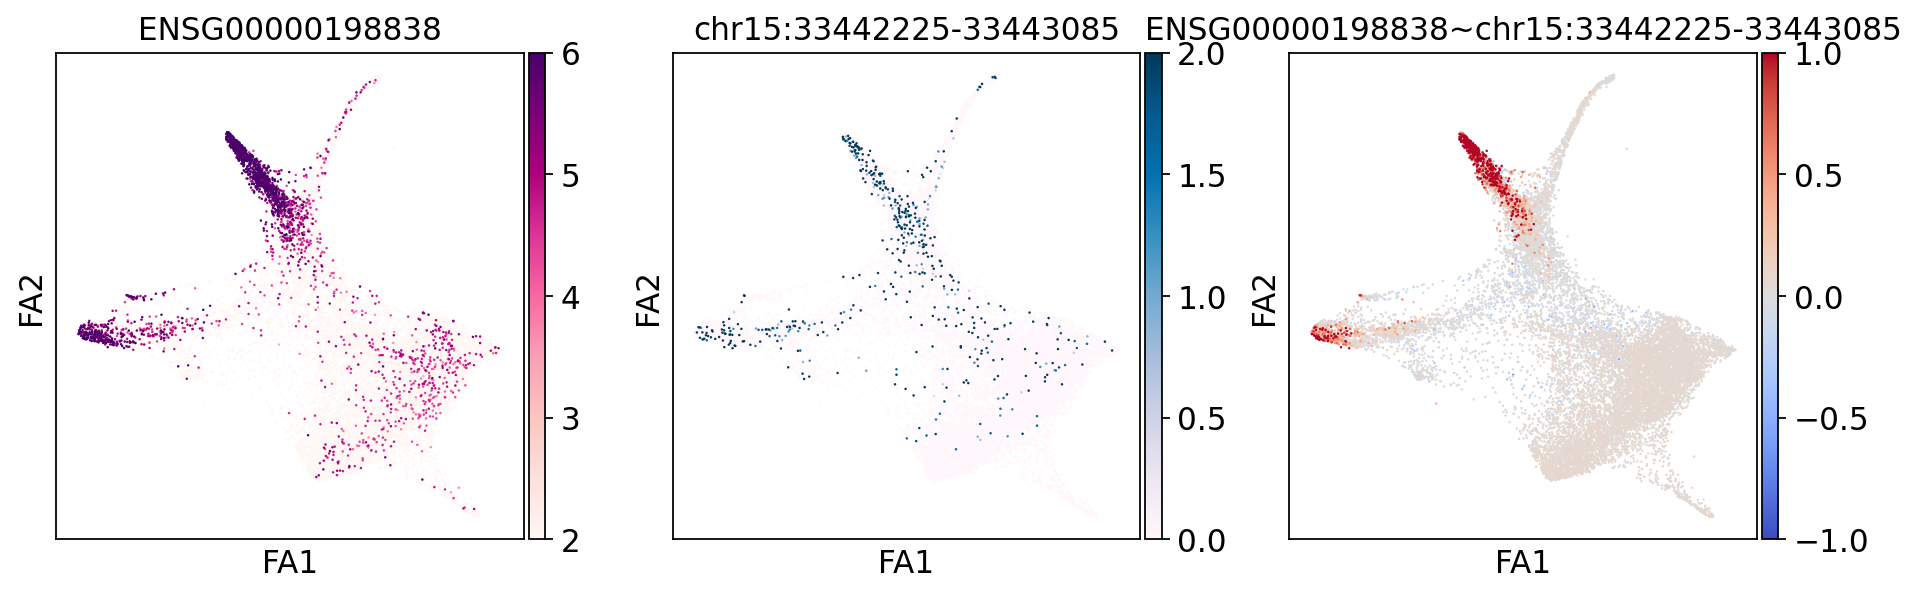

In [23]:
treasmo.pl.visualize_marker(mudata, 
                            gene=gene,
                            peak=peaks[0], 
                            mods=['rna','atac'],
                            basis='draw_graph_fa',
                            cmaps=['RdPu','PuBu','coolwarm'],
                            vmins=[2,0,-1], vmaxs=[6,2,1], size=5,
                            figsize=(14,4),
                            save=f'figures/curve_{gene}_peak0.pdf')

ENSG00000198838 and chr15:33678116-33679062


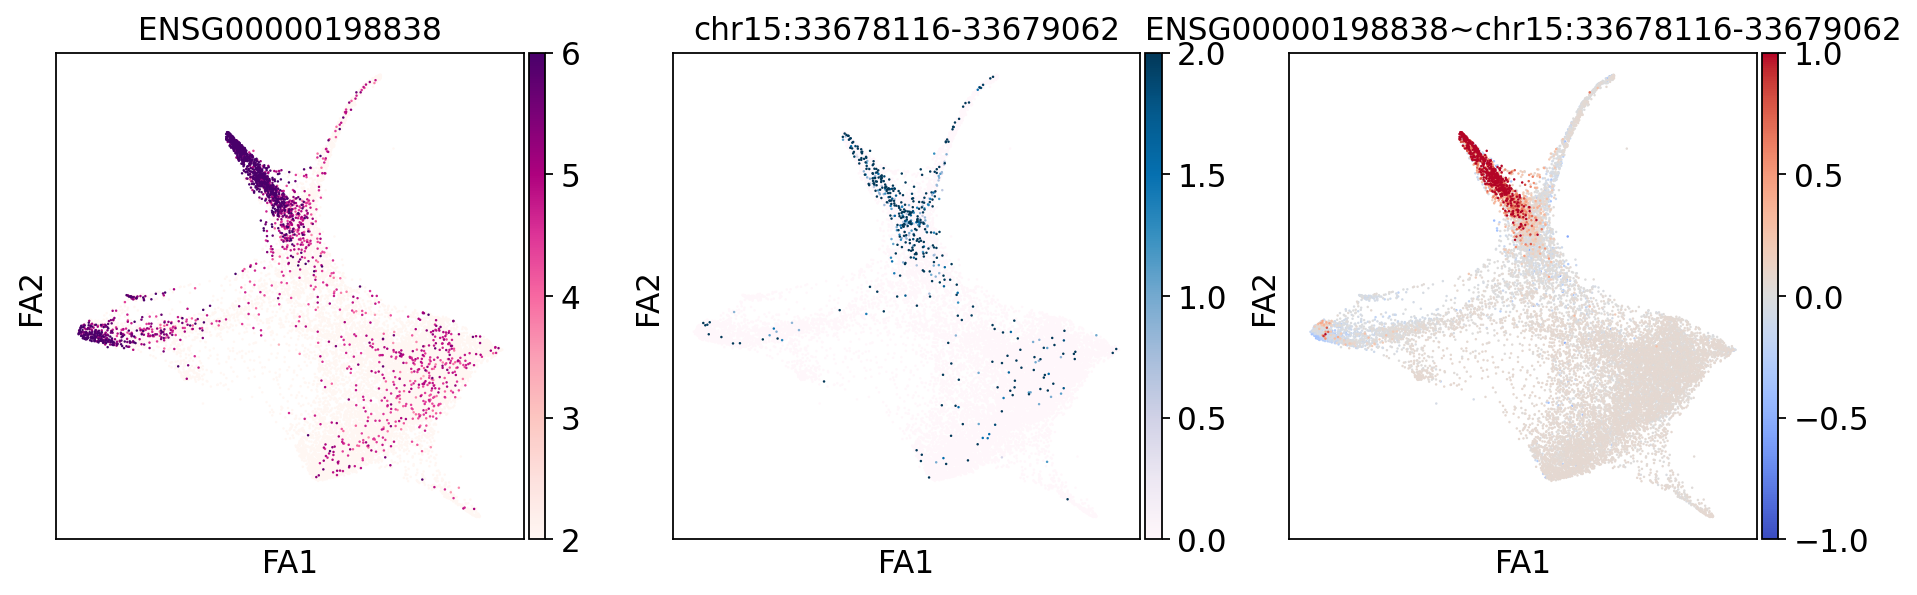

In [24]:
treasmo.pl.visualize_marker(mudata, 
                            gene=gene,
                            peak=peaks[1], 
                            mods=['rna','atac'],
                            basis='draw_graph_fa',
                            cmaps=['RdPu','PuBu','coolwarm'],
                            vmins=[2,0,-1], vmaxs=[6,2,1], size=5,
                            figsize=(14,4),
                            save=f'figures/curve_{gene}_peak1.pdf')

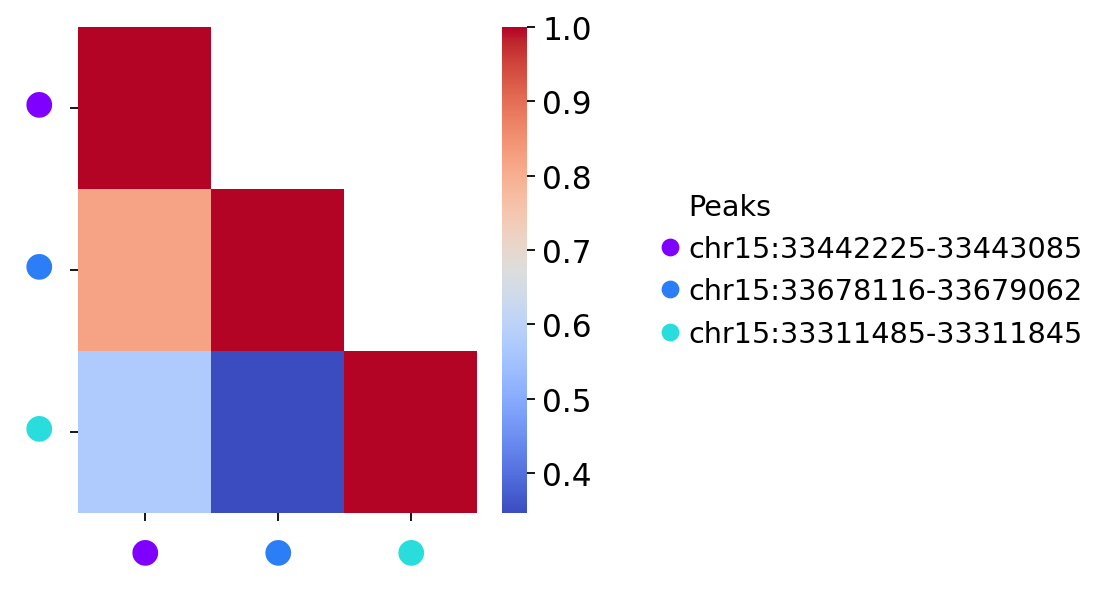

In [25]:
treasmo.pl.DynamicSumMtx(mudata, 
                        gene=gene,
                        ident='annotation',
                        path=['HSC','5','7','EryP'],
                         cmap='coolwarm',
                         save=f'figures/DynamicCompare_{gene}.pdf')

In [26]:
prpDf = treasmo.ds.TimeBinProportion(mudata, ident='annotation',
                                path=['HSC','5','7','EryP'],
                                pseudotime=['dpt_pseudotime'],
                                bins=100)

Empty bins removed. 101 bins left


In [27]:
somDict = treasmo.ds.DynamicModule(mudata, ident='annotation',
                                   path=['HSC','5','7','EryP'],
                                   pseudotime=['dpt_pseudotime'],
                                   fitted=200,
                                   features = dynamicDf.index.to_numpy(),
                                   num_iteration=5000, som_shape=(1,3), sigma=0.35, learning_rate=.1, random_seed=1)

Empty bins removed. 101 bins left
Start training...
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 2.9018480695325857


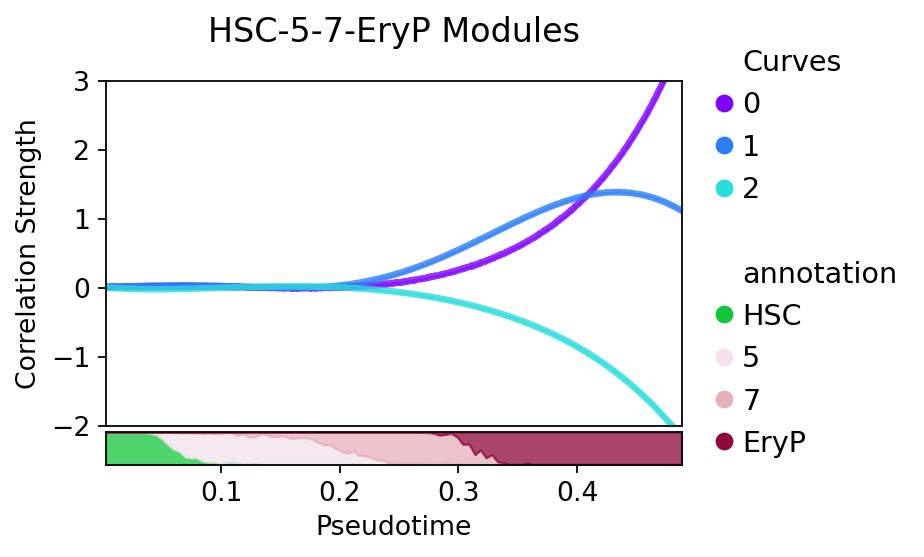

In [28]:
path = ['HSC','5','7','EryP']
treasmo.pl.DynamicModule(mudata, somDict, prpDf,
                                  split=False,
                                  #xlim=(0,0.52),
                                  ylim=(-2.0,3.0),
                        save=f"figures/curve_sum_{'_'.join(path)}.pdf")

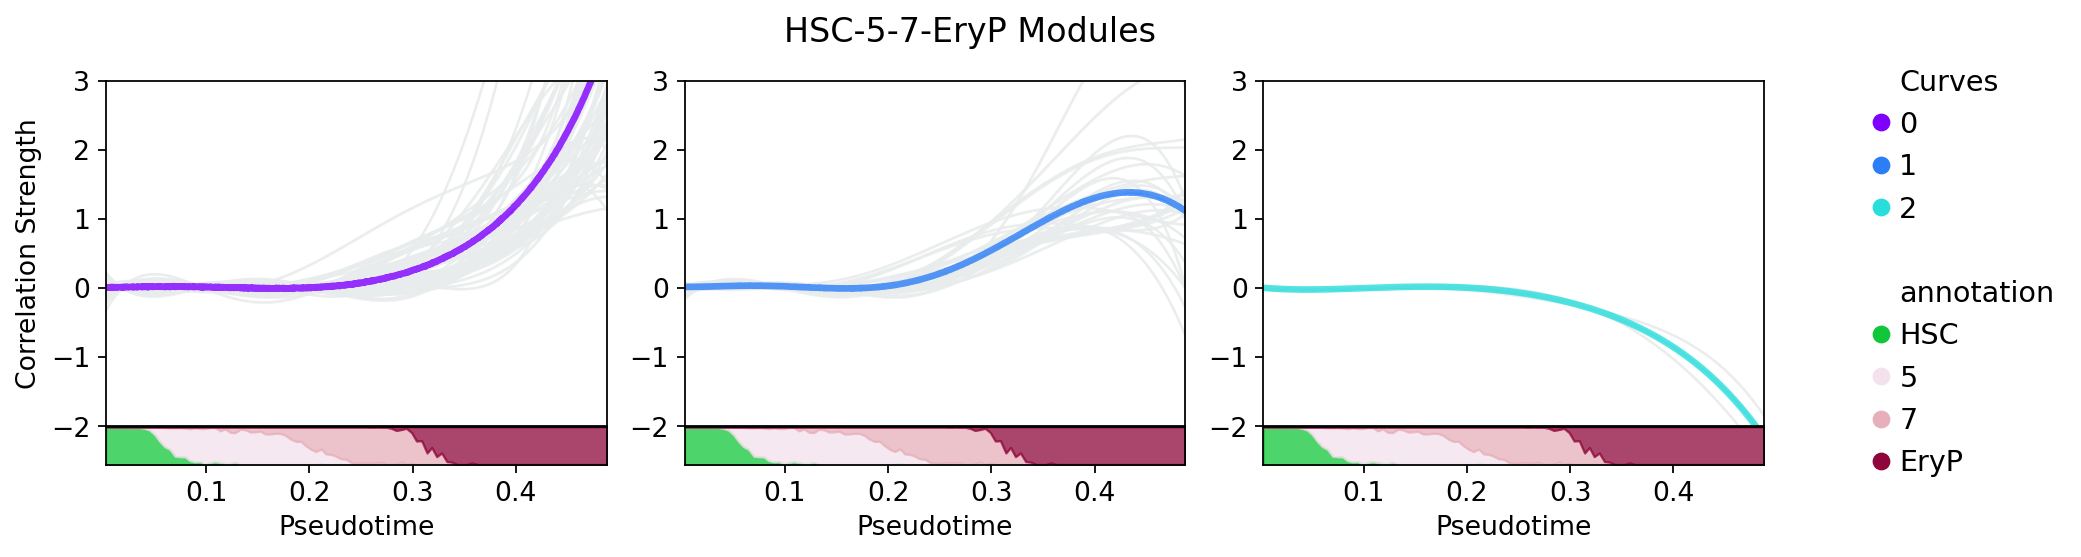

In [29]:
treasmo.pl.DynamicModule(mudata, somDict, prpDf,
                                  split=True,
                                  n_cols=3,
                                  #xlim=(0,0.52),
                                  ylim=(-2.0,3.0),
                         save=f"figures/curve_split_{'_'.join(path)}.pdf")

In [30]:
path = ['HSC','5','7','EryP']
for mod in somDict.keys():
    somDf = somDict[mod].copy()
    outDir = os.path.join(os.getcwd(), 'results/somModule', '_'.join(path))
    if not os.path.exists(outDir):
        os.makedirs(outDir)
    somDf.to_csv(f"{outDir}/timebin_{mod}.csv")